In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

### Project description:

We were asked to create a model that predicts the amount of pure gold ore recovered from raw gold feed material. Ultimately, the model will help to optimize the costly gold processing production. The performance of our model will be measured in "final sMAPE", a variation of MAE that consists of measures of sMAPEs of rougher and final inputs. 

### Let's import data sets

In [7]:
try:
    train_raw = pd.read_csv('/datasets/gold_recovery_train.csv')
except:
    train_raw = pd.read_csv(r"C:\Users\vlady\Downloads\gold_recovery_train.csv")
    
print('Data train_raw has been read correctly!')

try:
    test_raw = pd.read_csv('/datasets/gold_recovery_test.csv')
except:
    test_raw = pd.read_csv(r"C:\Users\vlady\Downloads\gold_recovery_test.csv")
    
print('Data test_raw has been read correctly!')

try:
    full_raw = pd.read_csv('/datasets/gold_recovery_full.csv')
except:
    full_raw = pd.read_csv(r'C:\Users\vlady\Downloads\gold_recovery_full.csv')
    
print('Data full_raw has been read correctly!')

Data train_raw has been read correctly!
Data test_raw has been read correctly!
Data full_raw has been read correctly!


In [8]:
# train_raw = pd.read_csv(r"C:\Users\vlady\Downloads\gold_recovery_train.csv")
# test_raw = pd.read_csv(r"C:\Users\vlady\Downloads\gold_recovery_test.csv")
# full_raw = pd.read_csv(r"C:\Users\vlady\Downloads\gold_recovery_full.csv")

train_raw.name = "train_raw"
test_raw.name = "test_raw"
full_raw.name = "full_raw"

datas = [train_raw, test_raw, full_raw]

### Let's inspect the info of the datasets:

In [9]:
for data in datas:
    print()
    print(data.name.upper())
    print("******************************")
    print(data.info())


TRAIN_RAW
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol             

### Let's inspect the duplicates, duplicated dates, number of Nans

In [10]:
def inspector(data):
    print(f"DATA NAME: {data.name.upper()}:")
    print("-----------------------------------------------")
    print("NUMBER OF COLUMNS:", len(data.columns))
    print(f"NUMBER OF ROWS", len(data))
    print("NUMBER OF DUPLICATES:", data.duplicated().sum())
    print("NUMBER OF DUPLICATED DATES:", data.date.duplicated().sum())
    print("NUMBER OF NANS:\n",data.isna().sum())

    print("-----------------------------------------------")
    print(" ")
    print(" ")


a, b, c = map(inspector, datas)

DATA NAME: TRAIN_RAW:
-----------------------------------------------
NUMBER OF COLUMNS: 87
NUMBER OF ROWS 16860
NUMBER OF DUPLICATES: 0
NUMBER OF DUPLICATED DATES: 0
NUMBER OF NANS:
 date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64
-----------------------------------------------
 
 
DATA NAME: TEST_RAW:
-----------------------------------------------
NUMBER OF COLUMNS: 53
NUMBER OF ROWS 5856
NUMBER OF DUPLICATES: 0
NUMBER OF DUPLICATED DATES: 0
NUMBER OF NANS:
 date   

### Seems like our test data contains only 53 rows vs 87 rows in the train and full datasets. In order to avoid info (target) leakage from train set into our model we will have to trim our training set to contain only the columns that are present in the test set. 

### Another problem of our data sets is that they contain numerous nans:

In [11]:

for data in datas:
    print(data.name.upper(), data.isna().sum().sum())
    

TRAIN_RAW 30320
TEST_RAW 2360
FULL_RAW 36587


### In order to deal with the task of MAE calculation we must make sure that our data is clean of Nans.  Let's FFILL the columns that are essential for recovery calculation:

In [12]:
essential_columns = ["rougher.output.concentrate_au", "rougher.input.feed_au","rougher.output.tail_au"]


train_raw[essential_columns] = train_raw[essential_columns].ffill(axis = 0, )
full_raw[essential_columns] = full_raw[essential_columns].ffill(axis = 0, )


In [13]:
# let's check:
train_raw[essential_columns].isna().sum().sum()

0

### Note that we don't really need to drop the NANS from the unessential columns for the mae calculation in the next task, but we rather have a clean dataset for our future L model. Therefore we decided to  drop tha nans at this stage:

In [15]:
for data in datas:
    data.dropna(inplace = True)
    print(data.name.upper(), data.isna().sum().sum())

TRAIN_RAW 0
TEST_RAW 0
FULL_RAW 0


## 1.2 Calculation of rougher.output.recovery and MAE calculation

### Let's calculate an estimate/prediction of rougher.output.recovery based on the formula provided and then compare the resulted values with true values:

In [16]:

# RECOVERY  ROUGHER FORMULA =  (C*(F-T)) / (F*(C-T)) * 100
C = train_raw["rougher.output.concentrate_au"]
F = train_raw["rougher.input.feed_au"]
T = train_raw["rougher.output.tail_au"]

train_raw["prediction.rougher.output.recovery"] = (C*(F-T)) / (F*(C-T)) * 100   # Saving the calculation in a new column

In [17]:
mae = (train_raw["prediction.rougher.output.recovery"] - train_raw["rougher.output.recovery"]).abs().mean()
mae

9.460144184559453e-15

<div class="alert alert-success">
<b>Reviewer's comment</b>

Recovery data was validated successfully!

</div>

#  Data preprocessing.

### Our data contains float dtypes in columns and object dtype in dates column. Let's convert dates to datetime:


In [18]:
for data in datas:
    data["date"] = data["date"] .astype('datetime64') # Convertion
    data.set_index('date', inplace = True)



In [19]:
train_raw.sample(5)

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2017-04-20 21:59:59                     3.545503                    11.123636   
2017-07-08 17:59:59                     4.125392                    10.064415   
2018-02-07 20:59:59                     6.678504                    10.456879   
2018-03-03 20:59:59                     6.558592                     8.656222   
2018-04-08 02:59:59                     4.794637                    11.578276   

                     final.output.concentrate_sol  \
date                                                
2017-04-20 21:59:59                      9.678743   
2017-07-08 17:59:59                     11.623719   
2018-02-07 20:59:59                     10.124111   
2018-03-03 20:59:59                      9.885211   
2018-04-08 02:59:59                      8.654557   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2017-04-20 21:59:59                    46.621304              66.861272   
2017-07-08 17:59:59                    45.774168              43.297947   
2018-02-07 20:59:59                    44.587851              75.895790   
2018-03-03 20:59:59                    44.136733              76.591376   
2018-04-08 02:59:59                    45.001896              66.508861   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2017-04-20 21:59:59              8.196023              2.705240   
2017-07-08 17:59:59              6.360444              2.244638   
2018-02-07 20:59:59             14.291349              3.613385   
2018-03-03 20:59:59             12.950695              2.002300   
2018-04-08 02:59:59              9.041509              1.501078   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2017-04-20 21:59:59              11.414742              2.686891   
2017-07-08 17:59:59              11.259605              2.192048   
2018-02-07 20:59:59              11.882623              3.657696   
2018-03-03 20:59:59              11.978088              2.365482   
2018-04-08 02:59:59               8.937497              1.885340   

                     primary_cleaner.input.sulfate  ...  \
date                                                ...   
2017-04-20 21:59:59                     143.509139  ...   
2017-07-08 17:59:59                     109.404085  ...   
2018-02-07 20:59:59                     194.145315  ...   
2018-03-03 20:59:59                     166.104141  ...   
2018-04-08 02:59:59                     104.919050  ...   

                     secondary_cleaner.state.floatbank4_a_level  \
date                                                              
2017-04-20 21:59:59                                 -398.327064   
2017-07-08 17:59:59                                 -501.520727   
2018-02-07 20:59:59                                 -499.567742   
2018-03-03 20:59:59                                 -500.824928   
2018-04-08 02:59:59                                 -501.478999   

                     secondary_cleaner.state.floatbank4_b_air  \
date                                                            
2017-04-20 21:59:59                                 23.004851   
2017-07-08 17:59:59                                 15.054631   
2018-02-07 20:59:59                                 14.983582   
2018-03-03 20:59:59                                 14.952480   
2018-04-08 02:59:59                                 16.099475   

                     secondary_cleaner.state.floatbank4_b_level  \
date                                                              
2017-04-20 21:59:59                                 -400.901193   
2017-07-08 17:59:59                                 -379.965356   


### As we know from our previous checks, we have no duplicated dates in our dataset. It might help us in the future in case we deside to restore missing columns in the test dataset from the full dataset. For now, let's remove the columns in the train set that not appear in the test set: 


### 1.3. Features not available in the test set

In [20]:
#Let's see which columns are missing from the test dataset

missing_columns_list =  list(set(train_raw.columns) - set(test_raw.columns))

In [21]:
train_raw[missing_columns_list].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11017 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 35 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_sol                        11017 non-null  float64
 1   rougher.calculation.sulfate_to_au_concentrate       11017 non-null  float64
 2   rougher.output.concentrate_au                       11017 non-null  float64
 3   secondary_cleaner.output.tail_au                    11017 non-null  float64
 4   rougher.output.concentrate_pb                       11017 non-null  float64
 5   final.output.tail_au                                11017 non-null  float64
 6   final.output.concentrate_ag                         11017 non-null  float64
 7   rougher.output.recovery                             11017 non-null  float64
 8   rougher.output.tail_sol                  

### There are 35 columns missing from the test_raw dataset. These columns contain parameters of the "output" type. In order to prevent target leakage during the training of our future model we will drop these columns after the 2.3

<div class="alert alert-success">
<b>Reviewer's comment</b>

Right, that's a good idea!

</div>

## 2.1. Let's look how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

### Purification stage 1
* rougher.output.concentrate_ag                   
* rougher.output.concentrate_pb                   
* rougher.output.concentrate_au 

###  Purification stage 2
* primary_cleaner.output.concentrate_ag             
* primary_cleaner.output.concentrate_pb             
* primary_cleaner.output.concentrate_au 

###  Purification stage 3
* final.output.concentrate_ag                        
* final.output.concentrate_pb                        
* final.output.concentrate_au


In [22]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()


fig.add_trace(go.Histogram(x = train_raw["rougher.output.concentrate_ag"], name='Rougher Output Ag'))

fig.add_trace(go.Histogram(x = train_raw["primary_cleaner.output.concentrate_ag"], name='Primary Cleaner Output Ag'))

fig.add_trace(go.Histogram(x = train_raw["final.output.concentrate_ag"], name='Final Output Ag'))

fig.update_layout(barmode="overlay", title = "Measures of Ag in different stages of processing / Train Dataset")
fig.update_traces(opacity=0.7)
fig.show()

### Note the abnormal residuals at axis x = 0. These are outliers, we will remove later on. Let's explore the concentration of Pb:

In [23]:
fig = go.Figure()

fig.add_trace(go.Histogram(x = train_raw["rougher.output.concentrate_pb"], name='Rougher Output Pb'))

fig.add_trace(go.Histogram(x = train_raw["primary_cleaner.output.concentrate_pb"], name='Primary Cleaner Output Pb'))

fig.add_trace(go.Histogram(x = train_raw["final.output.concentrate_pb"], name='Final Output Pb'))

fig.update_layout(barmode="overlay", title = "Measures of Pb in different stages of processing / Train Dataset")
fig.update_traces(opacity=0.7)
fig.show()

In [24]:
fig = go.Figure()

fig.add_trace(go.Histogram(x = train_raw["rougher.output.concentrate_au"], name='Rougher Output Au'))

fig.add_trace(go.Histogram(x = train_raw["primary_cleaner.output.concentrate_au"], name='Primary Cleaner Output Au'))

fig.add_trace(go.Histogram(x = train_raw["final.output.concentrate_au"], name='Final Output Au'))

fig.update_layout(barmode="overlay", title = "Measures of Au in different stages of processing  / Train Dataset")
fig.update_traces(opacity=0.7)
fig.show()

## Analysis and interpretation:

Concentration distribution of Au, Ag, and Pb, is impacted by the processes used in different stages of Gold preprocessing. As we move from the raw preprocessing to a more advanced stages of gold purification the concentration of Gold increases, yet decreases for the silver and just slightly increases for the lead (Fb).

<div class="alert alert-success">
<b>Reviewer's comment</b>

Makes sense!

</div>

### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

In [25]:


fig = go.Figure()

fig.add_trace(go.Histogram(x = train_raw["rougher.input.feed_size"], name='Train Feed Size'))

fig.add_trace(go.Histogram(x = test_raw["rougher.input.feed_size"], name='Test Feed Size'))


fig.update_layout(barmode="overlay", title = "Measures of Particles size in Train and Test datasets")
fig.update_traces(opacity=0.7)
fig.show()



The particle size remains the same for the Train (blue) and Test (red) datasets.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Distributions were compared successfully!

</div>

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

In [26]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

r_in = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']

# We create a column that sums the values of all three metals per each instance of rougher.input.feed.
train_raw["combined_rougher_in"] = train_raw[r_in].sum(axis=1)
# # Here we create the same column but for the test dataset
# essential_test["combined_rougher_in"] = essential_test[r_in].sum(axis=1)


# We do the same for the rougher.output.concentrate
r_out = ["rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb"]
train_raw["combined_rougher_out"] = train_raw[r_out].sum(axis=1)
# essential_test["combined_rougher_out"] = essential_test[r_out].sum(axis=1)


# Finnaly we do this for the final.output.concentrate instances.
fin = ["final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb" ] 
train_raw["combined_final"] =  train_raw[fin].sum(axis =1)
# essential_test["combined_final"] =  essential_test[fin].sum(axis =1)


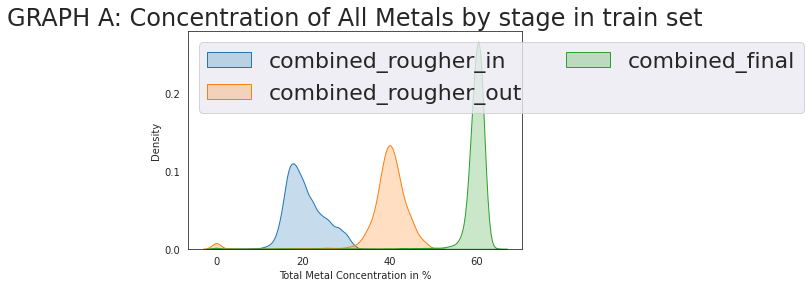

In [27]:
datas = ["combined_rougher_in","combined_rougher_out", "combined_final"] 
sns.set_style('white')
fig, ax = plt.subplots()

for data in datas:
    with sns.axes_style('white'):
        sns.kdeplot(train_raw[data], shade=True)

sns.set(rc={'figure.figsize':(22,5)})
sns.set(font_scale=2) 
plt.legend(datas, ncol=2, loc='upper left', fancybox=True);
sns.set_style('white')
ax.set_xlabel( "Total Metal Concentration in %") 
ax.set_title( "GRAPH A: Concentration of All Metals by stage in train set") 
plt.show()


## Analysis and interpretation 

* Graph A features a distribution of combined concentration of metals Ag, Au, Pb during the proccessing of raw gold during three stages: raw in, raw out and final.
    
* Graph A clearly show that as we move to more advanced stages of processing, the (combined) concentration and density of metals increase, meaning that as we move from stage to stage the raw metal losses its' unessential ingridients, thus  the concentration of the essential materials increases. 

* Special attention deserves the concentration around 0 on the x axis. Closer inspection of the distribution of these values (see Graph C bellow) shows that as we move from the raw to a more advanced stages, the concentration of metals around 0 subsides, till it almost disapears. Note that the "strenght" of these values is 1/100 of their normal values. For example combined rougher_out is 0.002 around the 0 (x axis) and ~ 0.14 on 40 on the x axis.
 


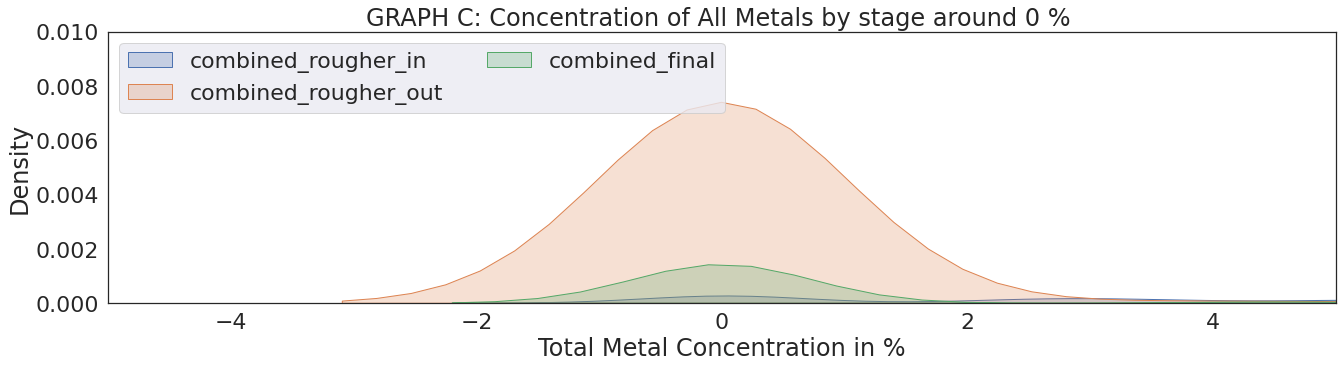

In [28]:
fig, ax = plt.subplots()
datas = ["combined_rougher_in","combined_rougher_out", "combined_final"] 
sns.set_style('white')
for data in datas:
    with sns.axes_style('white'):
        sns.kdeplot(train_raw[data], shade=True)

sns.set(rc={'figure.figsize':(22,5)})
sns.set(font_scale=2) 

plt.legend(datas, ncol=2, loc='upper left', fancybox=True)
sns.set_style('white')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.01)
ax.set_xlabel( "Total Metal Concentration in %") 
ax.set_title( "GRAPH C: Concentration of All Metals by stage around 0 % ") 
plt.show()

Before proceeding to our model, we decided to remove these anomalies from both our datasets, the test and the train set.
As we have shown before, as we proceed to the more advanced stages of gold processing and increase the concentration of essential metals (Au, Ag, Pb) the density of these metals around 0 on x axis shrinks to insignificant levels.

In [29]:
print("Before dropping outliers:", len(train_raw), len(train_raw.columns))
for combination in ["combined_rougher_in","combined_rougher_out", "combined_final"]:
    train_raw = train_raw[train_raw[combination]>5]
 #   essential_test = essential_test[essential_test[combination]>5]
print("After dropping outliers:", len(train_raw), len(train_raw.columns))


Before dropping outliers: 11017 90
After dropping outliers: 10775 90


<div class="alert alert-success">
<b>Reviewer's comment</b>

Rows with abnormal total concentration were detected and removed

</div>

### Let'sa check the combined final minimal value. It should be above 5  

In [30]:
train_raw[ "combined_final"].describe()

count    10775.000000
mean        59.624215
std          3.440612
min          8.899410
25%         59.155630
50%         60.147261
75%         60.956607
max         64.856303
Name: combined_final, dtype: float64

### Now let's recalculate our list of columns to drop:

In [31]:
columns_to_drop =  list(set(train_raw.columns) - set(test_raw.columns))

In [32]:
columns_to_drop.remove("rougher.output.recovery")  # We keep "rougher.output.recovery" in train data - this is our target

In [33]:
columns_to_drop.remove("final.output.recovery")  # We keep "final.output.recovery" in train data - this is our target

In [34]:
columns_to_drop

['final.output.concentrate_sol',
 'combined_rougher_in',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_au',
 'secondary_cleaner.output.tail_au',
 'rougher.output.concentrate_pb',
 'final.output.tail_au',
 'combined_final',
 'final.output.concentrate_ag',
 'combined_rougher_out',
 'rougher.output.tail_sol',
 'final.output.tail_pb',
 'final.output.concentrate_pb',
 'secondary_cleaner.output.tail_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_sol',
 'final.output.tail_ag',
 'primary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'prediction.rougher.output.recovery',
 'secondary_cleaner.output.tail_ag',
 'rougher.calculati

In [35]:
train_raw = train_raw.drop(columns = columns_to_drop)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, now the train set has the same set of features as the test set

</div>

## 3. Build the model

### 3.1. Write a function to calculate the final sMAPE value.


# SMAPE FUNCTION

In [36]:

def smape2(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100 
    return smape

def f_smape(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    f_smape = (.25 * (smape2(true_rough, predicted_rough))) + (.75 * (smape2(true_final, predicted_final)))
    return f_smape

smape_score = make_scorer(f_smape, greater_is_better=False) 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Functions for SMAPE calculation are correct, scoring object is initialized properly

</div>

### 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.



### Splitting the train set 

In [37]:


features = train_raw.drop(columns = ["rougher.output.recovery", "final.output.recovery"], axis =1).values
target =  train_raw[["rougher.output.recovery", "final.output.recovery"]].values


## Linear Regression

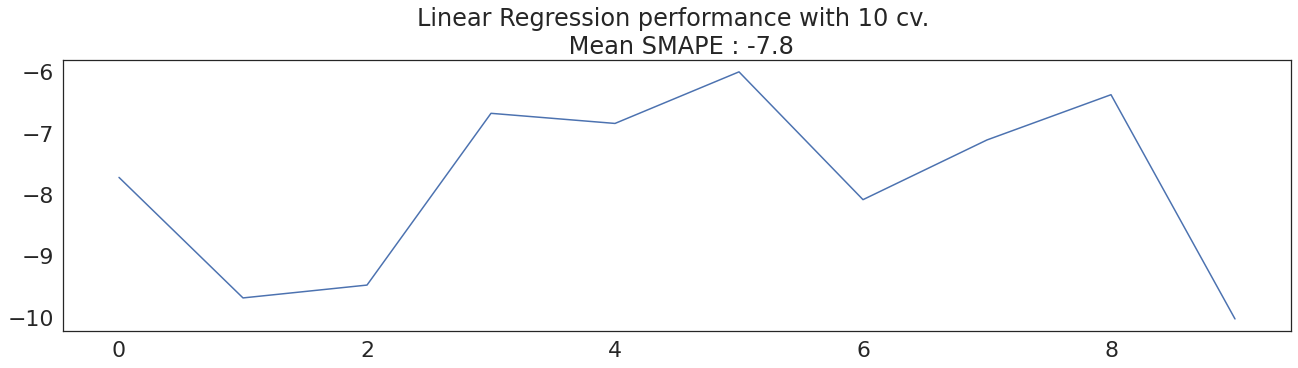

In [38]:
linear_reg_model = LinearRegression()

scores = cross_val_score(linear_reg_model, features, target, cv=10, scoring= smape_score)#smape_score)
plt.plot(scores)
plt.title(f"Linear Regression performance with 10 cv. \n Mean SMAPE : {round(np.mean(scores),2)}")
plt.show()


### RandomForestRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
forest = RandomForestRegressor(random_state = 21)


In [41]:
from sklearn.model_selection import GridSearchCV

search_space = { "n_estimators": [1,2,4,8,16,],
                 "max_depth" :   [4,6,8,10], 
               }

GS = GridSearchCV( estimator =  forest, 
                 param_grid = search_space,
                 scoring = smape_score,
                 cv = 5, 
                 verbose = 4)


In [42]:
GS.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 2/5] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 3/5] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 4/5] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 5/5] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 1/5] END ....................max_depth=4, n_estimators=2; total time=   0.2s
[CV 2/5] END ....................max_depth=4, n_estimators=2; total time=   0.2s
[CV 3/5] END ....................max_depth=4, n_estimators=2; total time=   0.2s
[CV 4/5] END ....................max_depth=4, n_estimators=2; total time=   0.2s
[CV 5/5] END ....................max_depth=4, n_estimators=2; total time=   0.2s
[CV 1/5] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 2/5] END ....................max_depth=4, n

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=21),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'n_estimators': [1, 2, 4, 8, 16]},
             scoring=make_scorer(f_smape, greater_is_better=False), verbose=4)

In [43]:
print(GS.best_params_)

{'max_depth': 4, 'n_estimators': 16}


In [44]:
print(GS.best_score_)

-8.237571533205784


<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you tried a couple of models and did some hyperparameter tuning using cross-validation with our target metric

</div>

### Before we test our models on the test set we must complete the two missing target columns from the full dataset:

In [45]:

missing_columns = ["rougher.output.recovery",'final.output.recovery']
for missing_column in missing_columns:
    test_raw[missing_column] = test_raw.index.map(full_raw.set_index(full_raw.index)[missing_column])

len(test_raw.columns)

54

<div class="alert alert-success">
<b>Reviewer's comment</b>

Targets for the test set were identified correctly

</div>

### Let's make sure that we have no devision by 0. We will drop all instances that are == to 0 in the target columns:


In [46]:

test_raw = test_raw[test_raw["final.output.recovery"] > 0]
test_raw = test_raw[test_raw["rougher.output.recovery"] > 0]



In [47]:
features2 = test_raw.drop(columns = ["rougher.output.recovery", "final.output.recovery"], axis =1).values
target2 = test_raw[["rougher.output.recovery", "final.output.recovery"]].values


<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

### Testing Linear Reg on the Test set: 

In [50]:
linear_reg_model.fit(features, target)

test_pred = linear_reg_model.predict(features2)


In [54]:
print("Linear regressor final sMAPE score :", f_smape(target2,test_pred))


FINAL SMAPE : 6.790602943052523


### Testing ForestRegressor on the Test set: 

In [62]:
forest = RandomForestRegressor(random_state = 21,
                              n_estimators=16,  
                               max_depth=4,)

# Fitting / training on the train data
forest.fit(features, target)

# Testing on the test data
test_pred = forest.predict(features2)

# Evaluating the result using smape metric
print("RandomForestRegressor final sMAPE :", f_smape(target2,test_pred))

RandomForestRegressor final sMAPE : 7.926557228366827


### Let's evaluate the results of our two model with a baseline performance:A dummy regressor that predicts the mean of the dataset:

In [63]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)

dummy_preds = dummy_regr.predict(features2)
print(" Simple baseline (dummy regressor) final sMAPE :", f_smape(target2, dummy_preds))

 Simple baseline (dummy regressor) final sMAPE : 7.389272711951142


### The dummy regressor has a better sMAPE than the Forest but worst score than the Linear regressor.

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Very good!

</div>

### Conclutions:
    
#### Analyzing the data of Gold ore purification we showed that the various processing stages have distinct impact on the concentration of gold, silver and lead in the the raw material as it moves from one stage to the next. Using MAE as a metric, we calculated the Au recovery and showed that that it was identical to the true recovery metrics in the data. The datasets required some preproccessing and cleaning: our calculations and models couldn't tolerate division by zero, therefore we had to drop the instances of both Nans and zeros in the target columns.  We then created two prediction models:  Linear Reg and Forest Reg and calculated the result on our leading metric called  "final sMAPE", a variation of MAE.  We then compared our result to a dummy regressor that always predicts the mean of the dataset. The forest regression model performed worse than the dummy regressor but the Linear regressor showed a better result. 


<div class="alert alert-success">
<b>Reviewer's comment V2</b>

SMAPE is a variation of MAPE (mean average percentage error), not MAE (mean absolute error). The difference is that MAE works with absolute differences, while MAPE and SMAPE work with percentage differences.
    
On a sidenote, your conclusions and comments would be more readable if you used regular markdown text for them and not styled everything as a header (compare the text above with the text below) :)

</div>

### Conclusions:
    
Analyzing the data of Gold ore purification we showed that the various processing stages have distinct impact on the concentration of gold, silver and lead in the the raw material as it moves from one stage to the next. Using MAE as a metric, we calculated the Au recovery and showed that that it was identical to the true recovery metrics in the data. The datasets required some preproccessing and cleaning: our calculations and models couldn't tolerate division by zero, therefore we had to drop the instances of both Nans and zeros in the target columns.  We then created two prediction models:  Linear Reg and Forest Reg and calculated the result on our leading metric called  "final sMAPE", a variation of MAE.  We then compared our result to a dummy regressor that always predicts the mean of the dataset. The forest regression model performed worse than the dummy regressor but the Linear regressor showed a better result. 
